In [1]:
import os
import json
import re
import scipy.io as spio
import numpy as np
from bokeh.plotting import figure
import tifffile as tf
import seaborn as sns
# %matplotlib notebook
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import skimage.color
from json_tricks.np import dump, dumps, load, loads
from mat2py import loadmat
from skimage import color
import cPickle as pkl

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [2]:
analysis_id = 'analysis04' #options.analysis_id

#avg_dir = options.avg_dir
#flyback_corrected = options.flyback_corrected

source = '/nas/volume1/2photon/projects'
experiment = 'scenes' #'gratings_phaseMod' #'retino_bar' #'gratings_phaseMod'
session = '20171003_JW016' #'20170927_CE059' #'20170902_CE054' #'20170825_CE055'
acquisition = 'FOV1' #'FOV1_zoom3x' #'FOV1_zoom3x_run2' #'FOV1_planar'
functional_dir = 'functional' #'functional_subset'

stim_on_sec = 0.5
iti_pre = 1.0 #float(options.iti_pre)

custom_mw = True #options.custom_mw
# spacing = int(options.gap)
curr_slice_idx = 20 #int(options.sliceidx)

In [3]:
roi_interval = 1 #int(options.roi_interval)

avg_alpha = 1 #float(options.avg_alpha) # 1
avg_width = 1.2 #float(options.avg_width) #1.2
trial_alpha = 0.5 #float(options.trial_alpha) #0.8 #0.5 #0.5 #0.7
trial_width = 0.3 #float(options.trial_width) #0.2 #0.3

stim_offset = -0.5 #float(options.stimbar_offset) #-.75 #2.0
ylim_min = -1 #float(options.ymin) #-3
ylim_max = 1 #float(options.ymax) #50 #3 #100 #5.0 # 3.0

# backgroundoffset =  0.3 #0.8

color_by_roi = True

cmaptype = 'rainbow'


In [4]:
# ---------------------------------------------------------------------
# Get relevant stucts:
# ---------------------------------------------------------------------
acquisition_dir = os.path.join(source, experiment, session, acquisition)

# Create ROI dir in figures:
figbase = os.path.join(acquisition_dir, 'figures', analysis_id) #'example_figures'
if not os.path.exists(figbase):
    os.makedirs(figbase)
figdir = os.path.join(figbase, 'rois')
if not os.path.exists(figdir):
    os.mkdir(figdir)
print "Saving ROI subplots to dir:", figdir
 

# Load reference info:
ref_json = 'reference_%s.json' % functional_dir 
with open(os.path.join(acquisition_dir, ref_json), 'r') as fr:
    ref = json.load(fr)
    
# Load SI meta data:
si_basepath = ref['raw_simeta_path'][0:-4]
simeta_json_path = '%s.json' % si_basepath
with open(simeta_json_path, 'r') as fs:
    simeta = json.load(fs)

# Get stim params:
# if custom_mw is False:
currfile='File001'
# stim_on_sec = 2.
# iti = 1. #4.
nframes = int(simeta[currfile]['SI']['hFastZ']['numVolumes'])
framerate = float(simeta[currfile]['SI']['hRoiManager']['scanFrameRate'])
volumerate = float(simeta[currfile]['SI']['hRoiManager']['scanVolumeRate'])
frames_tsecs = np.arange(0, nframes)*(1/volumerate)

nframes_on = stim_on_sec * volumerate
#nframes_off = vols_per_trial - nframes_on
nframes_iti_pre = round(iti_pre * volumerate) 
print nframes_on
print nframes_iti_pre


Saving ROI subplots to dir: /nas/volume1/2photon/projects/scenes/20171003_JW016/FOV1/figures/analysis04/rois
2.296
5.0


In [5]:
# Get ROIPARAMS:
roi_dir = os.path.join(ref['roi_dir'], ref['roi_id'][analysis_id]) #, 'ROIs')
roiparams = loadmat(os.path.join(roi_dir, 'roiparams.mat'))
if 'roiparams' in roiparams.keys():
    roiparams = roiparams['roiparams']
maskpaths = roiparams['maskpaths']

print maskpaths

[ u'/nas/volume1/2photon/projects/scenes/20171003_JW016/FOV1/ROIs/manual2D/masks/20171003_JW016_FOV1_Slice05_Channel01_masks.mat'
 u'/nas/volume1/2photon/projects/scenes/20171003_JW016/FOV1/ROIs/manual2D/masks/20171003_JW016_FOV1_Slice10_Channel01_masks.mat'
 u'/nas/volume1/2photon/projects/scenes/20171003_JW016/FOV1/ROIs/manual2D/masks/20171003_JW016_FOV1_Slice15_Channel01_masks.mat'
 u'/nas/volume1/2photon/projects/scenes/20171003_JW016/FOV1/ROIs/manual2D/masks/20171003_JW016_FOV1_Slice20_Channel01_masks.mat'
 u'/nas/volume1/2photon/projects/scenes/20171003_JW016/FOV1/ROIs/manual2D/masks/20171003_JW016_FOV1_Slice25_Channel01_masks.mat'
 u'/nas/volume1/2photon/projects/scenes/20171003_JW016/FOV1/ROIs/manual2D/masks/20171003_JW016_FOV1_Slice30_Channel01_masks.mat'
 u'/nas/volume1/2photon/projects/scenes/20171003_JW016/FOV1/ROIs/manual2D/masks/20171003_JW016_FOV1_Slice35_Channel01_masks.mat'
 u'/nas/volume1/2photon/projects/scenes/20171003_JW016/FOV1/ROIs/manual2D/masks/20171003_JW016_F

In [6]:
# Get ROIPARAMS:
roi_dir = os.path.join(ref['roi_dir'], ref['roi_id'][analysis_id]) #, 'ROIs')
roiparams = loadmat(os.path.join(roi_dir, 'roiparams.mat'))
if 'roiparams' in roiparams.keys():
    roiparams = roiparams['roiparams']
maskpaths = roiparams['maskpaths']
print maskpaths
if not isinstance(maskpaths, list) and len(maskpaths)==1:
    maskpaths = [maskpaths] #[str(i) for i in maskpaths]


# Check slices to see if maskpaths exist for all slices, or just a subset:
if 'sourceslices' in roiparams.keys():
    slices = roiparams['sourceslices']
else:
    slices = np.arange(1, len(maskpaths)+1) #range(len(maskpaths))
print "Found masks for slices:", slices
if isinstance(slices, int):
    slices = [slices]
if not isinstance(slices, list): # i.e., only 1 slice
    slices = [int(i) for i in slices]
print "SLICES:", slices

# Load masks:
masks = dict(("Slice%02d" % int(slice_idx), dict()) for slice_idx in slices)
for sidx,maskpath in zip(sorted(slices), sorted(maskpaths, key=natural_keys)):
    slice_name = "Slice%02d" % int(sidx) #+1)
    print "Loading masks: %s..." % slice_name 
    tmpmasks = loadmat(maskpath); tmpmasks = tmpmasks['masks']
    masks[slice_name]['nrois'] =  tmpmasks.shape[2]
    masks[slice_name]['masks'] = tmpmasks


# Get masks for current slice:
slice_names = sorted(masks.keys(), key=natural_keys)
print "SLICE NAMES:", slice_names
curr_slice_name = "Slice%02d" % curr_slice_idx
currmasks = masks[curr_slice_name]['masks']
print currmasks.shape

nrois = masks[curr_slice_name]['nrois']
print "NROIS:", nrois, curr_slice_name
#rois_to_plot = np.arange(0, nrois)

[ u'/nas/volume1/2photon/projects/scenes/20171003_JW016/FOV1/ROIs/manual2D/masks/20171003_JW016_FOV1_Slice05_Channel01_masks.mat'
 u'/nas/volume1/2photon/projects/scenes/20171003_JW016/FOV1/ROIs/manual2D/masks/20171003_JW016_FOV1_Slice10_Channel01_masks.mat'
 u'/nas/volume1/2photon/projects/scenes/20171003_JW016/FOV1/ROIs/manual2D/masks/20171003_JW016_FOV1_Slice15_Channel01_masks.mat'
 u'/nas/volume1/2photon/projects/scenes/20171003_JW016/FOV1/ROIs/manual2D/masks/20171003_JW016_FOV1_Slice20_Channel01_masks.mat'
 u'/nas/volume1/2photon/projects/scenes/20171003_JW016/FOV1/ROIs/manual2D/masks/20171003_JW016_FOV1_Slice25_Channel01_masks.mat'
 u'/nas/volume1/2photon/projects/scenes/20171003_JW016/FOV1/ROIs/manual2D/masks/20171003_JW016_FOV1_Slice30_Channel01_masks.mat'
 u'/nas/volume1/2photon/projects/scenes/20171003_JW016/FOV1/ROIs/manual2D/masks/20171003_JW016_FOV1_Slice35_Channel01_masks.mat'
 u'/nas/volume1/2photon/projects/scenes/20171003_JW016/FOV1/ROIs/manual2D/masks/20171003_JW016_F

In [7]:
roi_interval = 1
tmprois = '0,3,36,37' #options.rois_to_plot
if len(tmprois)==0:
    rois_to_plot = np.arange(0, nrois, roi_interval) #int(nrois/2)
    sort_name = 'all' #% roi_interval
else:
    rois_to_plot = tmprois.split(',')
    rois_to_plot = [int(r) for r in rois_to_plot]
    roi_string = "".join(['r%i' % int(r) for r in rois_to_plot])
    print roi_string
    sort_name = 'selected_%s' % roi_string

print "ROIS TO PLOT:", rois_to_plot



r0r3r36r37
ROIS TO PLOT: [0, 3, 36, 37]


In [8]:
# Create ROI dir in figures:
figbase = os.path.join(acquisition_dir, 'figures', analysis_id) #'example_figures'
if not os.path.exists(figbase):
    os.makedirs(figbase)

if len(tmprois)==0:
    figdir = os.path.join(figbase, 'rois')
else:
    figdir = os.path.join(figbase, 'roi_subsets', sort_name, 'roi_traces')
if not os.path.exists(figdir):
    os.makedirs(figdir)
print "Saving ROI subplots to dir:", figdir
 

Saving ROI subplots to dir: /nas/volume1/2photon/projects/scenes/20171003_JW016/FOV1/figures/analysis04/roi_subsets/selected_r0r3r36r37/roi_traces


In [9]:
# Get PARADIGM INFO:
path_to_functional = os.path.join(acquisition_dir, functional_dir)
paradigm_dir = 'paradigm_files'
path_to_paradigm_files = os.path.join(path_to_functional, paradigm_dir)
#path_to_trace_structs = os.path.join(acquisition_dir, 'Traces', roi_method, 'Parsed')
path_to_trace_structs = os.path.join(acquisition_dir, 'Traces', ref['trace_id'][analysis_id], 'Parsed')
    

# Load stim trace structs:
print "Loading parsed traces..."
signal_channel = ref['signal_channel'][analysis_id] #int(options.selected_channel)

currchannel = "Channel%02d" % int(signal_channel)
stimtrace_fns = os.listdir(path_to_trace_structs)
stimtrace_fns = sorted([f for f in stimtrace_fns if 'stimtraces' in f and currchannel in f and f.endswith('.pkl')], key=natural_keys)
if len(stimtrace_fns)==0:
    print "No stim traces found for Channel %i" % int(selected_channel)
currslice = "Slice%02d" % curr_slice_idx
stimtrace_fn = [f for f in stimtrace_fns if currchannel in f and currslice in f][0]
with open(os.path.join(path_to_trace_structs, stimtrace_fn), 'rb') as f:
    stimtraces = pkl.load(f)


stimlist = sorted(stimtraces.keys(), key=natural_keys)
nstimuli = len(stimlist)


Loading parsed traces...


In [10]:
# ---------------------------------------------------------------------------
# PLOTTING:
# ----------------------------------------------------------------------------

colormap = plt.get_cmap(cmaptype)

if color_by_roi:
    colorvals = colormap(np.linspace(0, 1, nrois)) #get_spaced_colors(nrois)
else:
    colorvals = colormap(np.linspace(0, 1, nstimuli)) #get_spaced_colors(nstimuli)

colorvals255 = [c[0:-1]*255 for c in colorvals]

#colorvals = np.true_divide(colorvals255, 255.)
#print len(colorvals255)
#roi_interval = 10


# Get stim names:
stiminfo = dict()
if experiment=='gratings_phaseMod':
    print "STIM | ori - sf"
    for stim in stimlist: #sorted(stimtraces.keys(), key=natural_keys):
	
        ori = stimtraces[stim]['name'].split('-')[2]
        sf = stimtraces[stim]['name'].split('-')[4]
        stiminfo[stim] = (int(ori), float(sf))
        print stim, ori, sf

    oris = sorted(list(set([stiminfo[stim][0] for stim in stimlist]))) #, key=natural_keys)
    sfs = sorted(list(set([stiminfo[stim][1] for stim in stimlist]))) #, key=natural_keys)
    noris = len(oris)
    nsfs = len(sfs)
else:
    for stim in sorted(stimlist, key=natural_keys):
        stiminfo[stim] = int(stim)


In [12]:
calcs = dict((roi, dict((stim, dict()) for stim in stimlist)) for roi in rois_to_plot)
dfstruct = dict((roi, dict((stim, dict()) for stim in stimlist)) for roi in rois_to_plot)

for roi in rois_to_plot:
    for stimnum,stim in enumerate(stimlist):

        ntrialstmp = len(stimtraces[stim]['traces'])
        nframestmp = [stimtraces[stim]['traces'][i].shape[0] for i in range(len(stimtraces[stim]['traces']))]
        diffs = np.diff(nframestmp)
        if sum(diffs)>0:
            print "Incorrect frame nums per trial:", stimnum, stim
            print nframestmp
        else:
            nframestmp = nframestmp[0]

        raw = np.empty((ntrialstmp, nframestmp))
        for trialnum in range(ntrialstmp):
            raw[trialnum, :] = stimtraces[stim]['traces'][trialnum][0:nframestmp, roi].T

        ntrials = raw.shape[0]
        nframes_in_trial = raw.shape[1]

        xvals = np.empty((ntrials, nframes_in_trial))
        curr_dfs = np.empty((ntrials, nframes_in_trial))

        calcs[roi][stim] = dict()
        calcs[roi][stim]['zscores'] = []
        calcs[roi][stim]['mean_stim_on'] = []
        for trial in range(ntrials):
            if custom_mw is True:
                frame_on = stimtraces[stim]['frames_stim_on'][trial][0]
                frame_on_idx = [i for i in stimtraces[stim]['frames'][trial]].index(frame_on)
            else:
                frame_on = stimtraces[stim]['frames_stim_on'][trial][0]
                frame_on_idx = [i for i in stimtraces[stim]['frames'][trial]].index(frame_on)

            xvals[trial, :] = (stimtraces[stim]['frames'][trial] - frame_on) #+ stimnum*spacing
            baseline = np.mean(raw[trial, 0:frame_on_idx])


            df = (raw[trial,:] - baseline) / baseline
                    #print stim, trial
            curr_dfs[trial,:] = df

            stim_dur = stimtraces[stim]['frames_stim_on'][trial][1]-stimtraces[stim]['frames_stim_on'][trial][0]
            stim_interval = int(round(stim_dur))
            
            baseline_frames = curr_dfs[trial, 0:frame_on_idx]
            stim_frames = curr_dfs[trial, frame_on_idx:frame_on_idx+stim_interval]

            std_baseline = np.std(baseline_frames)
            mean_stim_on = np.mean(stim_frames)
            zval_trace = mean_stim_on / std_baseline

            calcs[roi][stim]['zscores'].append(zval_trace)
            calcs[roi][stim]['mean_stim_on'].append(mean_stim_on)
            calcs[roi][stim]['name'] = stimtraces[stim]['name']

            dfstruct[roi][stim]['name'] = stimtraces[stim]['name']
            dfstruct[roi][stim]['tsec'] = xvals/volumerate
            dfstruct[roi][stim]['df'] = curr_dfs
            dfstruct[roi][stim]['frame_on'] = (frame_on_idx, frame_on)
            dfstruct[roi][stim]['baseline_vals'] = baseline_frames
            dfstruct[roi][stim]['stim_on_vals'] = stim_frames
            dfstruct[roi][stim]['stim_on_dur'] = stim_dur 

In [13]:
dfstruct[roi][stim]['df'].shape

(8, 15)

In [14]:
print stim
dfstruct[roi][stim]['df'][0,:]

60


array([-0.18536157,  0.16328895, -0.00343303, -0.06947483,  0.09498047,
       -0.1871441 , -0.460356  , -0.1577873 , -0.42213054, -0.31473835,
       -0.06456736, -0.1584475 , -0.0940782 , -0.25325192, -0.15342999])

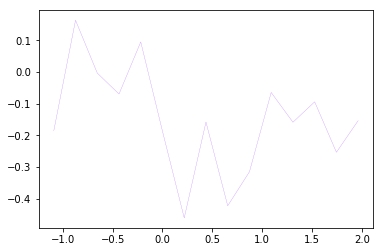

In [15]:
plt.figure()
plt.plot(dfstruct[roi][stim]['tsec'][0,:],  dfstruct[roi][stim]['df'][0,:], color=colorvals[0], alpha=trial_alpha, linewidth=trial_width)
plt.show()

In [16]:
if experiment=='gratings_phaseMod':
    nrows = nsfs
    ncols = noris
else:
    nrows = int(np.ceil(np.sqrt(len(stimlist))))
    ncols = int(np.ceil(len(stimlist)/float(nrows)))

print nrows, ncols

8 8


In [17]:
tsec = dfstruct[roi][stim]['tsec']
df = dfstruct[roi][stim]['df']
df.shape

(8, 15)

In [18]:
tsec

array([[-1.08885017, -0.87108014, -0.6533101 , -0.43554007, -0.21777003,
         0.        ,  0.21777003,  0.43554007,  0.6533101 ,  0.87108014,
         1.08885017,  1.30662021,  1.52439024,  1.74216028,  1.95993031],
       [-1.08885017, -0.87108014, -0.6533101 , -0.43554007, -0.21777003,
         0.        ,  0.21777003,  0.43554007,  0.6533101 ,  0.87108014,
         1.08885017,  1.30662021,  1.52439024,  1.74216028,  1.95993031],
       [-1.08885017, -0.87108014, -0.6533101 , -0.43554007, -0.21777003,
         0.        ,  0.21777003,  0.43554007,  0.6533101 ,  0.87108014,
         1.08885017,  1.30662021,  1.52439024,  1.74216028,  1.95993031],
       [-1.08885017, -0.87108014, -0.6533101 , -0.43554007, -0.21777003,
         0.        ,  0.21777003,  0.43554007,  0.6533101 ,  0.87108014,
         1.08885017,  1.30662021,  1.52439024,  1.74216028,  1.95993031],
       [-1.08885017, -0.87108014, -0.6533101 , -0.43554007, -0.21777003,
         0.        ,  0.21777003,  0.43554007, 

In [19]:
roi = 0

8 8


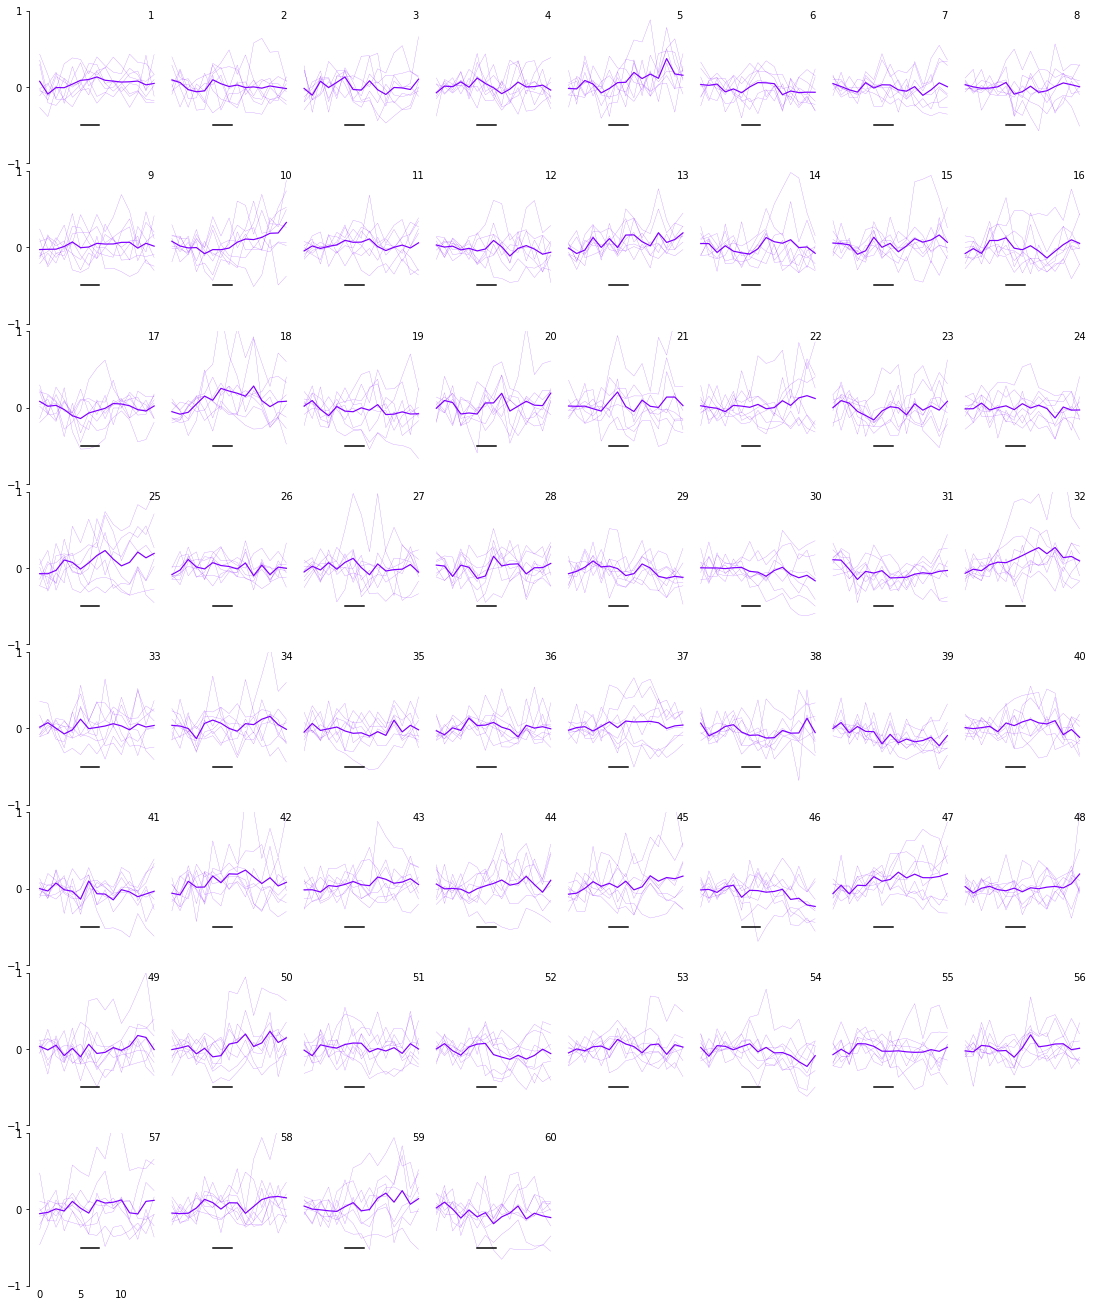

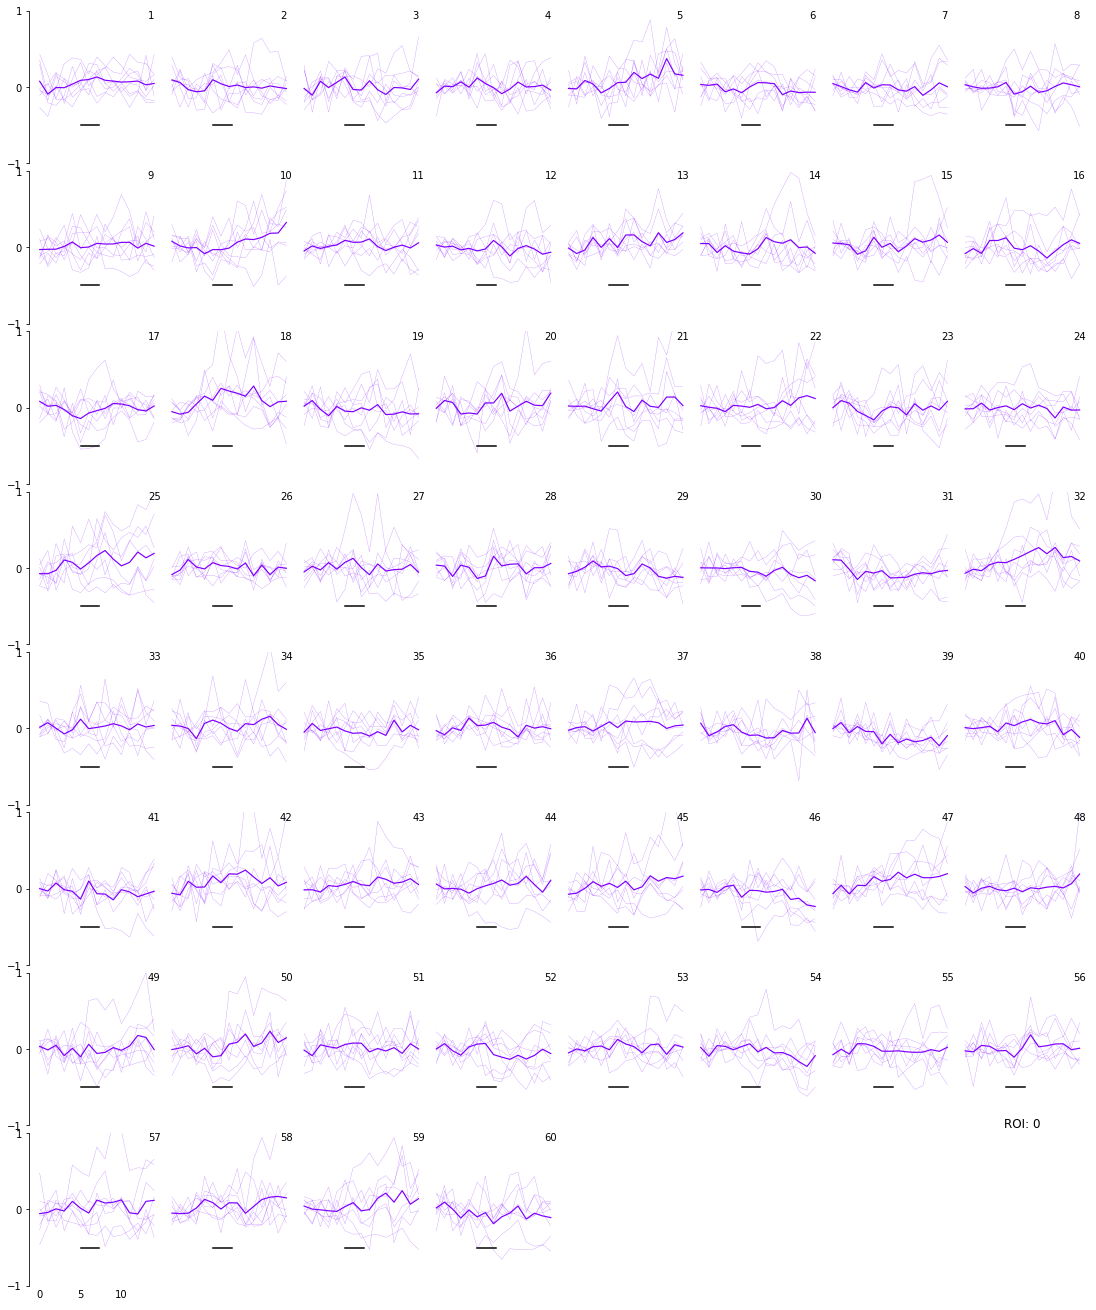

In [46]:
#plt.figure(figsize=(nrows, ncols))
from  matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator
def get_axis_limits(ax, scale=(0.9, 0.9)):
    return ax.get_xlim()[1]*scale[0], ax.get_ylim()[1]*scale[1]

#fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, sharex=True)


stimnames = [str(int(i)) for i in stimlist]
stimnums = [int(i) for i in stimlist]

# get the tick label font size
fontsize_pt = 8 #float(plt.rcParams['ytick.labelsize'])
dpi = 72.27
spacer = 20

# comput the matrix height in points and inches
matrix_height_pt = fontsize_pt * nrows * spacer
matrix_height_in = matrix_height_pt / dpi

# compute the required figure height 
top_margin = 0.01  # in percentage of the figure height
bottom_margin = 0.05 # in percentage of the figure height
figure_height = matrix_height_in / (1 - top_margin - bottom_margin)


# build the figure instance with the desired height
fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        sharex=True,
        sharey=True,
        figsize=(figure_height,figure_height), 
        gridspec_kw=dict(top=1-top_margin, bottom=bottom_margin, wspace=0.05, hspace=0.05))

row=0
col=0
print nrows, ncols
plotidx = 0
for stim in sorted(stimlist, key=natural_keys): #ROIs:

    if col==(ncols):
        row += 1
        col = 0
        
    #print stim, row, col
    
    ax_curr = axs[row, col] #, col]
    
    
    curr_dfs = dfstruct[roi][stim]['df']
    ntrials = df.shape[0]
    ntrialframes = df.shape[1]
    tsec = np.arange(0, ntrialframes)
    #print "ntrials:", ntrials

    for trial in range(ntrials):
        if color_by_roi:
            ax_curr.plot(tsec, curr_dfs[trial,:], color=colorvals[roi], alpha=trial_alpha, linewidth=trial_width)
        else:
            ax_curr.plot(tsec, curr_dfs[trial,:], color=colorvals[stimnum], alpha=trial_alpha, linewidth=trial_width)

    # Plot average:
    avg = np.mean(curr_dfs, axis=0) 
    if color_by_roi:
        ax_curr.plot(tsec, avg, color=colorvals[roi], alpha=avg_alpha, linewidth=avg_width)
    else:
        ax_curr.plot(tsec, avg, color=colorvals[stimnum], alpha=avg_alpha, linewidth=avg_width)

    # Plot stimulus ON period:
    frame_on_idx = dfstruct[roi][stim]['frame_on'][0]
    #print frame_on_idx
    stim_frames = [frame_on_idx, frame_on_idx+dfstruct[roi][stim]['stim_on_dur']]
    ax_curr.plot(stim_frames, np.ones((2,))*stim_offset, color='k')
        
#     tvals = dfstruct[roi][stim]['tsec'][0,:]
#     labels = [item.get_text() for item in ax_curr.get_xticklabels()]
#     for l in range(len(labels)):
#         labels[l] = tvals[0]

#     ax_curr.set_xticklabels(labels)

    # Deal with axes:  
    ax_curr.set_ylim([ylim_min, ylim_max])

#     ax_curr.tick_params(axis=u'x', which=u'both',length=0)
#     if col>0 and row<(nrows-1):
#         ax_curr.set_ylabel('')
#         ax_curr.tick_params(axis='y', which=u'both',length=0)
#         sns.despine(left=True, bottom=True, right=True, ax=ax_curr, trim=True)
#     elif col>0 and row==(nrows-1):

#         ax_curr.set_ylabel('')
#         ax_curr.tick_params(axis='y', which=u'both',length=0)
#         ax_curr.tick_params(axis='x', which=u'both',length=0)
#         sns.despine(left=True, right=True, bottom=True, offset=5, trim=True, ax=ax_curr)
    if col==0:
        ax_curr.set_xlabel('')
        ax_curr.tick_params(axis='x', which='both',length=0)
        ax_curr.yaxis.set_major_locator(MaxNLocator(5, integer=True))
        #ax_curr.xaxis.set_major_locator(MaxNLocator(noris, integer=True))
        sns.despine(bottom=True, right=True, offset=5, trim=True, ax=ax_curr)
    else:
        ax_curr.axis('off')
#         sns.despine(bottom=True, right=True, left=True, top=True, ax=ax_curr)
#         ax_curr.set_xlabel('')
#         ax_curr.tick_params(axis='x', which='both',length=0)
#         ax_curr.tick_params(axis='y', which='both',length=0)

    ax_curr.annotate(str(stim), xy=get_axis_limits(ax_curr))
    #ax_curr.legend().set_visible(False)

    col = col + 1
        
    #ptitle = "%2.0f., %0.2f" % (float(stiminfo[stim][0]), float(stiminfo[stim][1]))
    
    plotidx += 1

nleftover = (nrows*ncols)-plotidx
for p in range(nleftover):
    ax_curr = axs[row, col+p]
    ax_curr.axis('off')


#plt.subplots_adjust(top=1)
plt.title('ROI: %i' % int(roi))

figname = 'stimgrid_roi%i.png' % int(roi)
#plt.savefig(os.path.join(figdir, figname), bbox_inches='tight', pad=0)

# plt.show()

#plt.close(fig)

        
plt.show()